# Mezcal drops classifier
fastai image classifier of custom mezcal drop images
 
Inspired by  

*   [PyTorch Beginner Tutorial - Training an Image Classification Model and putting it online!
](https://www.youtube.com/watch?v=k1GIEkzQ8qc)
*   [Building projects with fastai - From Model Training to Deployment
](https://www.youtube.com/watch?v=pNaCrhxmN1w)

THIS VERSION IS MOSTLY BASED OFF OF THIS:
* [Image Classification with a Custom Dataset](https://walkwithfastai.com/Custom)

### Attempt #5(?) - 2022-01-30


In [6]:
!pip install -Uqq fastbook

import fastbook

In [7]:
import fastai
from fastai.vision.widgets import *
from fastbook import *
import zipfile
import os

In [2]:
# new path with renamed dataset
path_to_zip_file = "mezcal_data_renamed_2021.zip"
directory_to_extract_to = "data"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [9]:
path = Path("data")
files = get_image_files(path)
files

(#78) [Path('data/cuishe/cuishe_20210415145251.jpg'),Path('data/cuishe/cuishe_20210415145304.jpg'),Path('data/cuishe/cuishe_20210415145307.jpg'),Path('data/cuishe/cuishe_20210415145322.jpg'),Path('data/cuishe/cuishe_20210415145326.jpg'),Path('data/cuishe/cuishe_20210415145511.jpg'),Path('data/cuishe/cuishe_20210415145549.jpg'),Path('data/cuishe/cuishe_20210415145551.jpg'),Path('data/cuishe/cuishe_20210415145555.jpg'),Path('data/cuishe/cuishe_20210415145644.jpg')...]

### Delete any corrupt images

In [11]:
classes = os.listdir("data")

imgs = L()
for n in classes:
    print(n)
    path_n = path/n
    imgs += verify_images(path_n.ls())

cuishe
espadin
pechuga
tepextate
tobala


In [12]:
imgs

(#0) []

### View Data

In [13]:
mezcal = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(0.2),
                  get_y=parent_label,
                  item_tfms=RandomResizedCrop(460),
                  batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [21]:
dls = mezcal.dataloaders(path,  bs=9)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


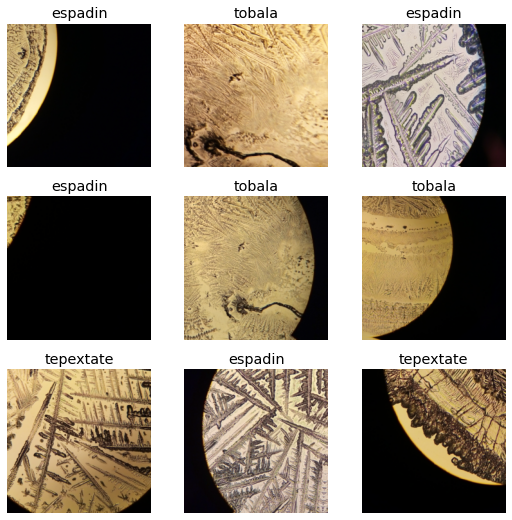

In [22]:
dls.show_batch(max_n=9)

In [23]:
dls.vocab

['cuishe', 'espadin', 'pechuga', 'tepextate', 'tobala']

## Training

In [24]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\socd0/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

C:\Users\socd0\anaconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [25]:
learn.fit_one_cycle(4)

C:\Users\socd0\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,3.157896,2.309311,0.733333,00:19
1,2.715475,1.746685,0.666667,00:19
2,2.359748,1.671903,0.533333,00:19
3,2.019987,1.562736,0.533333,00:19


SuggestedLRs(valley=0.0003981071640737355)

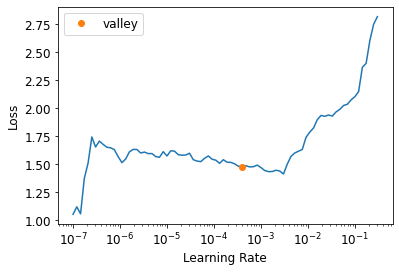

In [26]:
learn.save('stage-1')
learn.unfreeze()
learn.lr_find()

In [28]:
learn.fit_one_cycle(2, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.152181,1.113855,0.266667,00:24
1,1.205256,1.027563,0.466667,00:24
2,1.208367,1.264139,0.466667,00:23
3,1.110463,1.197603,0.333333,00:24
4,1.060263,1.084291,0.333333,00:23


In [29]:
learn.save('stage-2')

Path('models/stage-2.pth')

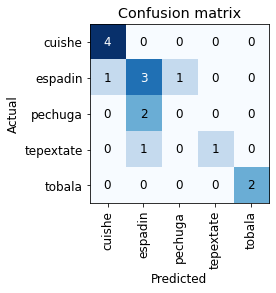

In [31]:
learn.load('stage-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

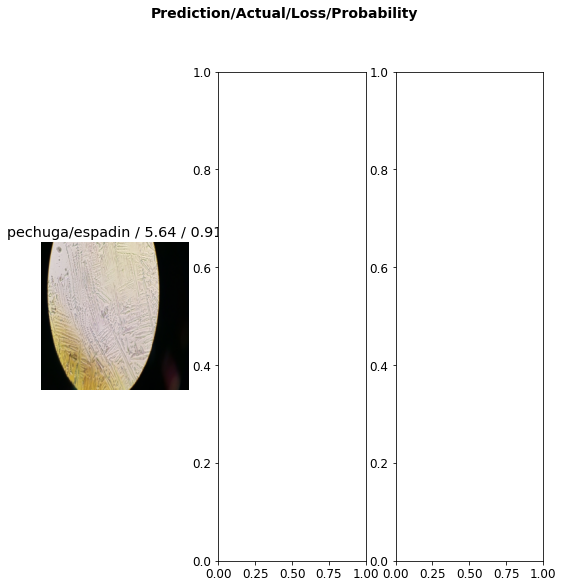

In [32]:
interp.plot_top_losses(3, figsize=(9,9))

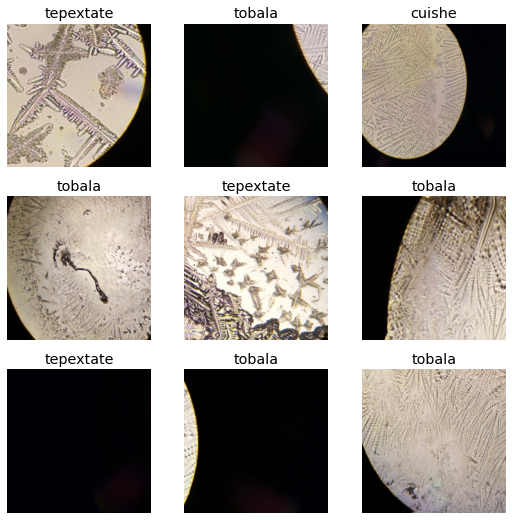

In [41]:
dls.train.show_batch()